# 候车问题

**问题描述**
到车站时看到当前站台上已有人数来估算下一班车到达时间是一个很直观的贝叶斯思维，接下来要通过计算来量化该问题。

思路：
1. 注意观察者偏差的存在
2. 先验模型认为乘客到达是到达率控制下的泊松分布，发车时间间隔通过观察估计
3. 观测到的数据有每次到站台时，站台已有人数，等待时间，和等待期间新到来的乘客

In [65]:
from matplotlib import pyplot as plt
import thinkplot
from thinkbayes2 import *
import numpy as np

OBSERVED_GAP_TIMES = [
    428.0, 705.0, 407.0, 465.0, 433.0, 425.0, 204.0, 506.0, 143.0, 351.0, 
    450.0, 598.0, 464.0, 749.0, 341.0, 586.0, 754.0, 256.0, 378.0, 435.0, 
    176.0, 405.0, 360.0, 519.0, 648.0, 374.0, 483.0, 537.0, 578.0, 534.0, 
    577.0, 619.0, 538.0, 331.0, 186.0, 629.0, 193.0, 360.0, 660.0, 484.0, 
    512.0, 315.0, 457.0, 404.0, 740.0, 388.0, 357.0, 485.0, 567.0, 160.0, 
    428.0, 387.0, 901.0, 187.0, 622.0, 616.0, 585.0, 474.0, 442.0, 499.0, 
    437.0, 620.0, 351.0, 286.0, 373.0, 232.0, 393.0, 745.0, 636.0, 758.0,
]


UPPER_BOUND = 1200
LOWER_BOUND = 60

In [66]:
# 观察者偏差相关函数

def ObserverBiasPmf(pmf):
    new_pmf = pmf.Copy()
    for i, prob in pmf.Items():
        new_pmf.Mult(i,i)
    new_pmf.Normalize()
    return new_pmf

def DeObserverBiasPmf(pmf):
    new_pmf = pmf.Copy()
    for i, prob in pmf.Items():
        new_pmf.Mult(i,100/i)
    new_pmf.Normalize()
    return new_pmf



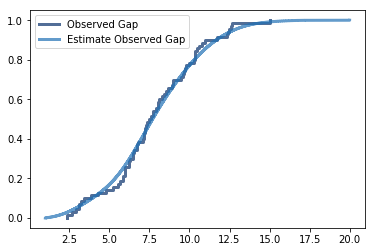

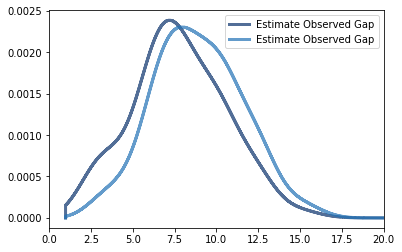

In [76]:
# 当前观察到的数据
cdf_gap = MakeCdfFromList(OBSERVED_GAP_TIMES, label="Observed Gap")
pmf_gap = EstimatedPdf(OBSERVED_GAP_TIMES).MakePmf(
                                            xs=np.linspace(
                                                UPPER_BOUND,
                                                LOWER_BOUND,
                                                UPPER_BOUND-LOWER_BOUND+1),
                                            label="Estimate Observed Gap")
thinkplot.Cdfs([cdf_gap.Scale(1/60), pmf_gap.MakeCdf().Scale(1/60)])
thinkplot.Config(legend = True)
plt.show()

# 这里有一个问题就是怎么理解 OBSERVED_GAP_TIMES 这个数据，在作者给出的代码中认为这个数据是具有观察者偏差的发车间隔数据
# 但是我觉得观察者自身是观察不到这套数据的，因为到站的时候观察者不知道上一辆车已经离开多长时间了，
# 者要么观测到的是下一辆车的到来时间，要么错过这辆车在等一辆车来观测发车间隔，假设观察者选择多等一辆车以观察到完整的发车间隔
# 如果相邻的两个发车间隔独立同分布，那么这样得到的数据没有观察者偏差
# 如果两次相邻的发车间隔时间几乎相同，那么此时的数据有观察者间隔
# 如果想书中假设的一样， 5分钟10分钟交替发车，那么观察者间隔将以相反的方式表现出来，即有2/3的可能性观察到5分钟的间隔
# OBSERVED_GAP_TIMES在这里应该是无偏差的
thinkplot.Pmfs([pmf_gap.Scale(1/60), ObserverBiasPmf(pmf_gap).Scale(1/60)])
thinkplot.Config(legend = True, xlim=[0,UPPER_BOUND/60])
plt.show()

# 另外书中为了说明贝叶斯决策，加上了意外情况导致的很长的发车间隔，这里不考虑

0.01770583901751731


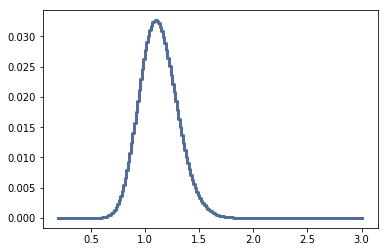

In [57]:
# 通过观察数据估计乘客的到达率
# 注：我上面那堆数据其实通过一个到达率为1/60为参数控制下的泊松分布生成出来的
PASSENGERS_DATA = [
 (1, 554.14489800278193, 12), (7, 286.92041253453095, 2), (4, 230.02605948241489, 0),
 (14, 156.89676100454017, 6), (2, 247.17083669702481, 7), (4, 212.86387056142877, 3),
 (8, 79.423576482033013, 0), (0, 351.33513351000494, 8), (3, 19.167469780424142, 2),
 (6, 103.0626022236226, 1), (4, 372.74744399830735, 7), (7, 139.21290093410784, 3),
 (8, 119.84405088086635, 4), (5, 269.69915208789513, 4), (6, 60.832771038209899, 2),
 (0, 346.84097371758469, 7), (1, 21.026056978500691, 0), (5, 408.02955089318704, 8),
 (6, 83.049106420939097, 0), (8, 370.83064254938608, 11), (1, 323.70994518819623, 4),
 (0, 230.33106322738917, 3), (3, 212.03078911770706, 3), (8, 226.75752677950851, 2), 
 (2, 644.91133736616928, 9), (1, 445.9315175481745, 7), (0, 386.97970675010589, 5),
 (2, 250.91196326906802, 3), (0, 360.22908279540502, 8), (5, 53.248181286539022, 1),
 (0, 372.16353599612376, 3), (5, 532.15758175624831, 14), (4, 311.46184220334038, 2),
 (5, 547.69531332713836, 11), (13, 30.496410420887287, 0), (5, 257.17311427378974, 8),
 (8, 256.35931013340149, 3), (5, 52.902383558642953, 1), (0, 363.46053641238836, 7),
 (5, 420.45488826395683, 8), (1, 127.79292369280992, 3), (0, 487.11559943563196, 9),
 (7, 306.11556445021881, 3), (7, 240.49833361376187, 2), (5, 531.75674766105362, 10),
 (6, 538.99316283091184, 16), (3, 449.4910103855226, 17), (12, 210.55916217091885, 1),
 (3, 429.23356272010176, 7), (2, 137.89589735822361, 1), (1, 221.95500859620219, 1),
 (6, 70.764311914251607, 0), (0, 633.24694183664303, 12), (1, 495.51381403826986, 11),
 (7, 91.934159589792273, 2), (6, 74.757664763906746, 1), (2, 312.99089894349027, 5),
 (2, 677.28856633490193, 15), (3, 254.91383572943931, 6), (4, 176.39510945448575, 1),
 (8, 156.23187904422593, 3), (2, 296.41042750791496, 6), (2, 384.62789719829595, 7),
 (8, 26.080763315286276, 1), (10, 126.12510354575562, 4), (0, 333.16393228610798, 4),
 (2, 346.13764142364721, 4), (3, 92.799125435537292, 0), (3, 282.86328424114765, 7),
 (2, 419.89698022434175, 5), (1, 355.1998413041452, 6), (9, 110.12678256425329, 2),
 (8, 87.02569758716794, 1), (3, 167.53764487696378, 2), (1, 366.8302068740806, 9),
 (3, 298.50546890885647, 3), (6, 174.99901158720064, 3), (0, 96.633655976128267, 1),
 (3, 45.742985639663402, 1), (1, 470.34687947603356, 5), (3, 225.33831563086108, 3),
 (6, 269.00284265811496, 8), (1, 515.92373364707157, 8), (12, 157.97430349684561, 3),
 (9, 102.33151045152795, 2), (6, 159.24323865240245, 3), (3, 222.24323920092192, 1),
 (1, 309.06614269417867, 7), (5, 218.37975369965909, 3), (6, 61.319862285161378, 3),
 (4, 362.80142216125716, 5), (0, 330.72886119798341, 4), (6, 150.61462511559191, 5),
 (11, 107.04986382856805, 0), (1, 203.01630040597092, 5), (1, 374.23625267264356, 2),
 (2, 616.7987259607155, 8), (2, 25.69142978560879, 1), (5, 1.3028739015356905, 0),
 (4, 217.07339497091709, 4)
]

# 点估计到达率
lam_data = [arrive/t for _,t,arrive in PASSENGERS_DATA]
print(sum(lam_data)/len(lam_data)) # 1/60=0.01666667, this get 0.0177

# bayes建模
class ArriveRate(Suite):
    # hypo是到达率
    # evidence是观察到 t 时间内来了 k 个人
    def Likelihood(self, data, hypo):
        lam = hypo
        t, k = data
        like = EvalPoissonPmf(k=k, lam=hypo*t)
        return like

arrive_rate = ArriveRate(MakePmfFromList(np.linspace(1/300, 3/60, num=200))) # 五分钟一个人->一分钟3个人， 200个估算点
arrive_rate.UpdateSet([(t,arrive) for _,t,arrive in PASSENGERS_DATA[:10]])
thinkplot.Pmf(arrive_rate.Scale(60))
plt.show()

In [58]:
print(arrive_rate.Mean())
print(arrive_rate.MAP())

0.0187415360188
0.0183417085427


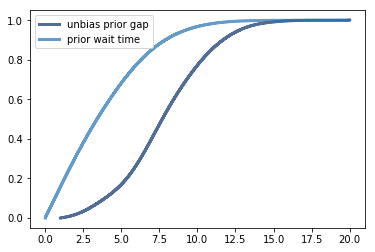

In [91]:
# 估算需要等待的时间
# 这是一个混合分布，gap是一个分布，等待时间是以gap的一个采样值为参数的均匀分布
# 这个不需要

class TimePrior():
    def __init__(self, pmf_gap, show=False):
        self.pmf_gap = pmf_gap
        self.pmf_gap.label = "unbias prior gap"
        
        self.pmf_elapsed_time_prior = self.ElapsedTimePrior(pmf_gap)
        self.pmf_elapsed_time_prior.label = "prior elapsed time"
        
        self.pmf_wait_time_prior = self.pmf_elapsed_time_prior
        self.pmf_wait_time_prior.label = "prior wait time"
        
        if show:
            thinkplot.Cdfs([pmf_gap.MakeCdf().Scale(1/60), 
                            self.pmf_elapsed_time_prior.MakeCdf().Scale(1/60)])
            thinkplot.Config(legend = True)
            plt.show()
        
    def ElapsedTimePrior(self, pmf_gap):
        mix = Pmf()
        for gap, prob in pmf_gap.Items():
            mix.Set(MakeUniformPmf(low=1, high=gap, n=gap),prob)
        return MakeMixture(mix)
    

                
prior = TimePrior(pmf_gap, show=True)

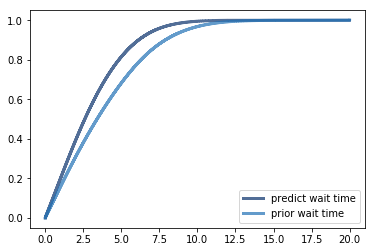

(139.0, 175.0)

In [103]:
def WaitTimePostPmf(time_prior, passengers, arrive_rate):
    elapsed = Elapsed(prior.pmf_elapsed_time_prior.Copy())
    elapsed.Update((arrive_rate, passengers))
    wait_time_pmf = KeepNotNegtive(time_prior.pmf_gap - elapsed)
    wait_time_pmf.label="predict wait time"
    return wait_time_pmf

def KeepNotNegtive(pmf):
    res = Pmf()
    for i, prob in pmf.Items():
        if i > 0:
            res.Set(i,prob)
    res.Normalize()
    return res

class Elapsed(Suite):
    def Likelihood(self, data, hypo):
        lam, k = data
        return EvalPoissonPmf(k=k, lam=hypo*lam)

predict_wait_time = WaitTimePostPmf(prior, 15, 0.0333)
thinkplot.Cdfs([predict_wait_time.MakeCdf().Scale(1/60), prior.pmf_elapsed_time_prior.MakeCdf().Scale(1/60)])
thinkplot.Config(legend=True)
plt.show()
predict_wait_time.CredibleInterval(10)

In [105]:
predict_cdf = predict_wait_time.MakeCdf()
print("五分钟内到达的置信度为", predict_cdf[300]

0.8151725284423027